<a href="https://colab.research.google.com/github/CarmenTheodoraCraciun/HairTextureClassification/blob/main/FNN_HairTexture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python
!pip install tensorflow
!pip install efficientnet

#Enviroment

In [ ]:
!rm -rf ./HairTextureClassification
!git clone https://github.com/CarmenTheodoraCraciun/HairTextureClassification.git

Cloning into 'HairTextureClassification'...
remote: Enumerating objects: 30844, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 30844 (delta 6), reused 5 (delta 5), pack-reused 30835 (from 4)
Receiving objects: 100% (30844/30844), 824.24 MiB | 15.45 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Updating files: 100% (16606/16606), done.


In [ ]:
import os
import cv2
import shutil
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam, SGD
from imblearn.over_sampling import SMOTE
from keras import Input
from numba import cuda
from collections import Counter
from collections import defaultdict
import collections
from math import gcd
from functools import reduce
from google.colab import files
from IPython import get_ipython
from IPython.display import display

##Optimizing the training environment and leaning up the TensorFlow session

* Enabling mixed precision for optimal performance on the GPU
* To avoid memory issues

In [ ]:
mixed_precision.set_global_policy('mixed_float16')
tf.keras.backend.clear_session()
collected = gc.collect()
print(f"Garbage collector freed {collected} unreachable objects.")

Garbage collector freed 0 unreachable objects.


#Loading data (unbalanced)

In [ ]:
def load_images_and_labels(input_dir, size=(96, 96)):
    images = []
    labels = []
    invalid_images = []

    for category in os.listdir(input_dir):
        category_dir = os.path.join(input_dir, category)
        if os.path.isdir(category_dir):
            for img_name in os.listdir(category_dir):
                img_path = os.path.join(category_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
                    images.append(img)
                    labels.append(category)

                    if img.shape[:2] != (96, 96):
                        invalid_images.append((img_name, img.shape[:2]))

    if invalid_images:
        print("Warning: Some images are not 96x96!")
        for img_name, shape in invalid_images:
            print(f" {img_name} has size {shape}")

    return np.array(images), np.array(labels)

In [ ]:
images, labels = load_images_and_labels('./HairTextureClassification/processData')

##Normalized images

In [ ]:
images = images.astype('float32') / 255.0
assert images.shape[1:] == (96, 96, 3), f"Error: Some images are not 96x96! Found {images.shape[1:]}"

##One-hot Encoding

* One-hot encoding is a technique used to convert categorical data into a numeric format that a machine learning model can understand
  * e.g. [0,0,0,1,0] means that the hair is straight.

In [ ]:
# Convert labels to numeric format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert labels to one-hot format
labels_categorical = to_categorical(labels_encoded).astype('float32')

print(f"Encoded labels shape: {labels_categorical.shape}")
print(f"Example labels (first 5):\n{labels_categorical[:5]}")

Encoded labels shape: (12980, 5)
Example labels (first 5):
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


##Split data

In [ ]:
datagen = ImageDataGenerator()

X_train, X_val, y_train, y_val = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

assert X_train.shape[1:] == (96, 96, 3), f"Error: X_train images are not 96x96! Found {X_train.shape[1:]}"
assert X_val.shape[1:] == (96, 96, 3), f"Error: X_val images are not 96x96! Found {X_val.shape[1:]}"

# The data generator
# train_generator = datagen.flow(X_train, y_train, batch_size=64, shuffle=True)
# validation_generator = datagen.flow(X_val, y_val, batch_size=64)
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
validation_generator = datagen.flow(X_val, y_val, batch_size=32)


# Calculating steps per epoch
steps_per_epoch = np.ceil(len(X_train) / 64).astype(int)
validation_steps = np.ceil(len(X_val) / 64).astype(int)

print(f"Train generator: {steps_per_epoch} batches, Total images: {len(X_train)}")
print(f"Validation generator: {validation_steps} batches, Total images: {len(X_val)}")

Train generator: 163 batches, Total images: 10384
Validation generator: 41 batches, Total images: 2596


In [ ]:
print(collections.Counter(labels))

Counter({np.str_('curly'): 4120, np.str_('dreadlocks'): 2335, np.str_('wavy'): 2317, np.str_('straight'): 2120, np.str_('kinky'): 2088})


#Balanced data (each category has 2000 images)

In [ ]:
def load_images_and_labels_eq(input_dir, size=(96, 96), max_per_category=2000):
    images = []
    labels = []
    invalid_images = []
    category_counts = defaultdict(int)  # Contor pentru fiecare categorie

    for category in os.listdir(input_dir):
        category_dir = os.path.join(input_dir, category)
        if os.path.isdir(category_dir):
            for img_name in os.listdir(category_dir):
                if category_counts[category] >= max_per_category:
                    continue  # Dacă am deja 2000 imagini, trecem la următoarea

                img_path = os.path.join(category_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
                    images.append(img)
                    labels.append(category)
                    category_counts[category] += 1  # Incrementăm numărul de imagini

                    if img.shape[:2] != (96, 96):
                        invalid_images.append((img_name, img.shape[:2]))

    if invalid_images:
        print("Warning: Some images are not 96x96!")
        for img_name, shape in invalid_images:
            print(f" {img_name} has size {shape}")

    return np.array(images), np.array(labels)

In [ ]:
images_eq, labels_eq = load_images_and_labels_eq('./HairTextureClassification/processData', max_per_category=2000)

In [ ]:
images_eq = images_eq.astype('float32') / 255.0
assert images_eq.shape[1:] == (96, 96, 3), f"Error: Some images are not 96x96! Found {images_eq.shape[1:]}"

In [ ]:
# Convert labels to numeric format
label_encoder_eq = LabelEncoder()
labels_encoded_eq = label_encoder_eq.fit_transform(labels_eq)

# Convert labels to one-hot format
labels_categorical_eq = to_categorical(labels_encoded_eq).astype('float32')

print(f"Encoded labels shape: {labels_categorical_eq.shape}")
print(f"Example labels (first 5):\n{labels_categorical_eq[:5]}")

Encoded labels shape: (10000, 5)
Example labels (first 5):
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [ ]:
datagen_eq = ImageDataGenerator()

X_train_eq, X_val_eq, y_train_eq, y_val_eq = train_test_split(images_eq, labels_categorical_eq, test_size=0.2, random_state=42)

assert X_train_eq.shape[1:] == (96, 96, 3), f"Error: X_train images are not 96x96! Found {X_train_eq.shape[1:]}"
assert X_val_eq.shape[1:] == (96, 96, 3), f"Error: X_val images are not 96x96! Found {X_val_eq.shape[1:]}"

# The data generator
train_generator_eq = datagen_eq.flow(X_train_eq, y_train_eq, batch_size=64, shuffle=True)
validation_generator_eq = datagen_eq.flow(X_val_eq, y_val_eq, batch_size=64)

# Calculating steps per epoch
# steps_per_epoch_eq = np.ceil(len(X_train) / 64).astype(int)
# validation_steps_eq = np.ceil(len(X_val) / 64).astype(int)
steps_per_epoch_eq = len(X_train_eq) // train_generator_eq.batch_size
validation_steps_eq = len(X_val_eq) // validation_generator_eq.batch_size

print(f"Train generator: {steps_per_epoch_eq} batches, Total images: {len(X_train_eq)}")
print(f"Validation generator: {validation_steps_eq} batches, Total images: {len(X_val_eq)}")

Train generator: 125 batches, Total images: 8000
Validation generator: 31 batches, Total images: 2000


In [ ]:
print(collections.Counter(labels_eq))

Counter({np.str_('straight'): 2000, np.str_('kinky'): 2000, np.str_('wavy'): 2000, np.str_('dreadlocks'): 2000, np.str_('curly'): 2000})


#Model evaluation

In [ ]:
def evaluate_model(model, history, X_val, y_val, label_encoder,y_pred_prob):
    """Evaluates the model on raw validation data."""

    # Calculează acuratețea
    y_pred = np.argmax(y_pred_prob, axis=1)
    accuracy = accuracy_score(np.argmax(y_val, axis=1), y_pred)
    print(f"Test accuracy: {accuracy:.4f}")

    # Classification report
    report = classification_report(np.argmax(y_val, axis=1), y_pred, target_names=label_encoder.classes_)
    print("Classification Report:\n", report)

    # Confusion matrix
    conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_pred)
    conf_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)

    # Afișează matricea de confuzie
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_df, annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Real Classes")
    plt.xlabel("Predicted Classes")
    plt.show()

    for i in range(5):
      print(np.round(y_pred_prob[i], 2), "→", label_encoder.classes_[np.argmax(y_pred_prob[i])])

    ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    for image, label in ds.take(1):
      print(image.shape, label)

#Building the Feedforward Neural Network model

A **Feedforward Neural Network (FNN)** is a type of artificial neural network where connections between nodes do not form cycles—data flows in one direction, from input to output.

Key Points:

* **Structure**: Consists of input layer → hidden layers → output layer.
* **No feedback loops**: Unlike recurrent networks, FNNs don't remember previous inputs.
* **Training**: Uses supervised learning, typically with backpropagation.

In [ ]:
fnn_model = Sequential([
    Input(shape=(96, 96, 3)),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
optimizer = Adam(learning_rate=0.001)
fnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

##Unbalnced data

In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weight_dict = dict(enumerate(class_weights))

history_fnn = fnn_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1858 - loss: 1.7621 - val_accuracy: 0.1687 - val_loss: 1.6560
Epoch 2/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2074 - loss: 1.6423 - val_accuracy: 0.3082 - val_loss: 1.6171
Epoch 3/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2345 - loss: 1.6113 - val_accuracy: 0.2103 - val_loss: 1.6068
Epoch 4/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2049 - loss: 1.6121 - val_accuracy: 0.2654 - val_loss: 1.6094
Epoch 5/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2192 - loss: 1.6102 - val_accuracy: 0.1953 - val_loss: 1.5971
Epoch 6/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2515 - loss: 1.5928 - val_accuracy: 0.2284 - val_loss: 1.5990
Epoch 7/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2100 - loss: 1.6094 - val_accuracy: 0.3116 - val_loss: 1.5881
Epoch 8/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2551 - loss: 1.5958 - val_accuracy: 0.197

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Test accuracy: 0.3116
Classification Report:
               precision    recall  f1-score   support

       curly       0.36      0.69      0.48       816
  dreadlocks       0.00      0.00      0.00       473
       kinky       0.00      0.00      0.00       438
    straight       0.25      0.32      0.28       424
        wavy       0.21      0.24      0.23       445

    accuracy                           0.31      2596
   macro avg       0.17      0.25      0.20      2596
weighted avg       0.19      0.31      0.24      2596



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


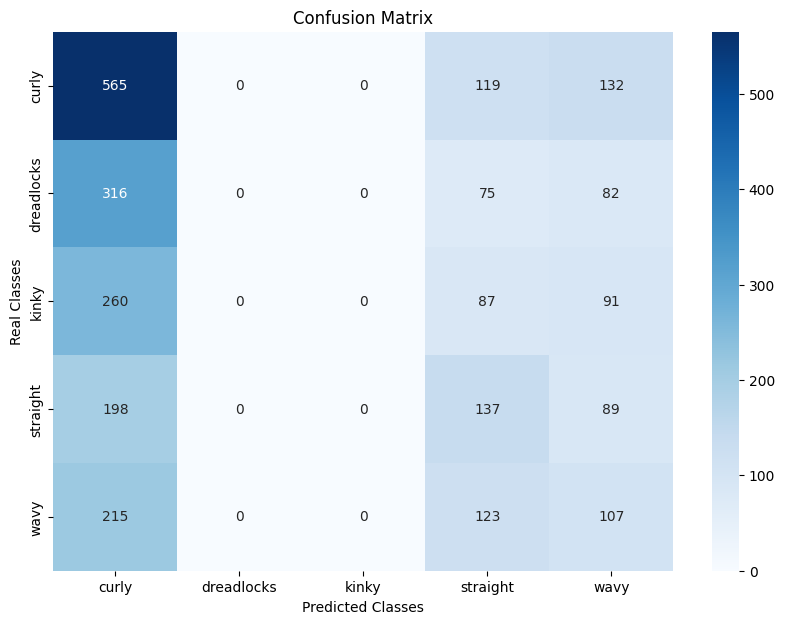

[0.19 0.19 0.18 0.22 0.22] → wavy
[0.19 0.18 0.17 0.23 0.23] → straight
[0.19 0.18 0.18 0.22 0.22] → straight
[0.2  0.19 0.19 0.21 0.22] → wavy
[0.19 0.18 0.17 0.23 0.23] → straight
(96, 96, 3) tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


In [ ]:
y_pred_prob = fnn_model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
evaluate_model(fnn_model, history_fnn, X_val, y_val, label_encoder,y_pred_prob)

##Balnce data

In [ ]:
history_fnn = fnn_model.fit(
    train_generator_eq,
    epochs=50,
    validation_data=validation_generator_eq,
    steps_per_epoch=steps_per_epoch_eq,
    validation_steps=validation_steps_eq,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/50
  4/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2272 - loss: 1.7183

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2340 - loss: 1.7044 - val_accuracy: 0.2384 - val_loss: 1.6011
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.2348 - loss: 1.6802 - val_accuracy: 0.2434 - val_loss: 1.6058
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.2216 - loss: 1.6835 - val_accuracy: 0.2414 - val_loss: 1.6142
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2340 - loss: 1.6775 - val_accuracy: 0.2404 - val_loss: 1.6120


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test accuracy: 0.2405
Classification Report:
               precision    recall  f1-score   support

       curly       0.00      0.00      0.00       387
  dreadlocks       0.00      0.00      0.00       415
       kinky       0.23      0.59      0.33       393
    straight       0.25      0.61      0.36       410
        wavy       0.00      0.00      0.00       395

    accuracy                           0.24      2000
   macro avg       0.10      0.24      0.14      2000
weighted avg       0.10      0.24      0.14      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


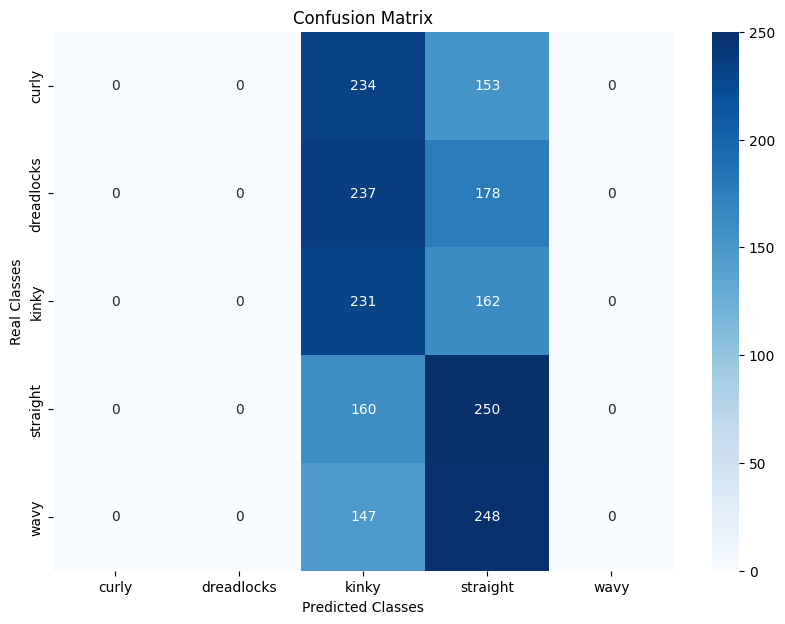

[0.14 0.19 0.21 0.23 0.22] → straight
[0.14 0.19 0.21 0.24 0.23] → straight
[0.13 0.18 0.2  0.25 0.24] → straight
[0.12 0.17 0.19 0.27 0.25] → straight
[0.13 0.18 0.2  0.26 0.24] → straight
(96, 96, 3) tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)


In [ ]:
y_pred_prob = fnn_model.predict(X_val_eq)
y_pred = np.argmax(y_pred_prob, axis=1)
evaluate_model(fnn_model, history_fnn, X_val_eq, y_val_eq, label_encoder_eq, y_pred_prob)

##Conclusion

In both variants, we can see that:
* FNN loses spatial information
  - Images have **structure** (texture, shapes, edges), and Flatten() destroys this information
  - FNN treats each pixel independently, without understanding the relationships between pixels.
* FNN is not robust to image variations
  - If an image is **slightly rotated, zoomed or moved**, FNN does not recognize it well.
  - The model does not learn **general features**, but only **specific patterns** from the training data.
* FNN has too many parameters for large images
  - A **96x96x3** image has **27,648 pixels**.
  - The model becomes **inefficient**, requiring more data and more training time.
* FNN does not detect complex features
  - Hair has **texture**, and FNN cannot detect **complex patterns**.
  - The model does not understand the relationships between parts of the image.